In [1]:
!pip install osmnx
!pip install geopandas
!pip install networkx
!pip install pyproj
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.9/102.9 kB 2.3 MB/s eta 0:00:00


In [2]:
import osmnx as ox
import geopandas as gpd
import networkx as nx
from pyproj import CRS
import pandas as pd
from shapely.geometry import Polygon, Point
import random
import matplotlib.pyplot as plt

In [3]:
#load Madison road network from OSMnx and Traffic Flow

gdf_edges=gpd.read_file('dane_county_roads.shp')
traffic_data = gpd.read_file('Traffic_Flow_Map.shp')
belt = int(gdf_edges.geometry[0].coords[0][0]//6 +31)
crs = CRS.from_proj4("+proj=utm +zone=%s +datum=WGS84 +units=m +no_defs"%belt)
gdf_edges = gdf_edges.to_crs(crs)
traffic_data =traffic_data.to_crs(crs)

In [4]:
# aggregate the road level and the traffic flow data with the road network
gdf_edges['id']=range(len(gdf_edges))
joined_gdf = gpd.sjoin(gdf_edges, traffic_data, how="left", predicate="intersects")
summary =joined_gdf.groupby('id')['AWT_Count'].agg(Total='sum').reset_index()
data = pd.merge(gdf_edges,summary,on='id',how='left')
data = data[['id', 'Total','highway', 'reversed','geometry']]
data.columns = ['id', 'passby','highway', 'reversed','geometry']

In [5]:
#assign the speed limit according the road level
data['speed'] = 0
data.loc[data['highway'] .isin(['motorway','trunk',"['motorway', \
                                'trunk']",'trunk_link','motorway_link']), 'speed'] = 80
data.loc[data['highway'] .isin(['primary_link','primary']), 'speed'] = 60
data.loc[data['highway'] .isin(['secondary_link','secondary']), 'speed'] = 40
data.loc[data['highway'].isin(['tertiary_link', 'tertiary']), 'speed'] = 30
data.loc[data['speed']==0, 'speed'] = 15

In [6]:
#Calculate speed taking into account traffic
data['flow_reduction_coe']=1 - data['passby']/data['passby'].max()
data['flow_reduction_speed'] = data['flow_reduction_coe']  * data['speed']
data['length'] =  data.geometry.length/1000
data['flow_reduction_time'] = 3600* data['length']/data['flow_reduction_speed']
data['nonreduction_time'] = 3600* data['length']/data['speed']

In [7]:
#add hospital data to road network
hospital=pd.read_csv('UW_hospitals.csv')
geometry = [Point(xy) for xy in zip(hospital['X'],hospital['Y'])]
gdf = gpd.GeoDataFrame(hospital, geometry=geometry)
gdf.set_crs('4326', inplace=True,allow_override=True)
hospital = gdf.to_crs(crs)
data['havehospital']=0
for i in range(len(hospital)):
    tempid = data.distance(hospital['geometry'][i]).idxmin()
    data.loc[tempid,'havehospital']=1

In [8]:
#build road network with direction
G = nx.DiGraph()
for line in data.itertuples():
    #nonreverse
    if line.reversed == 'False':
        first = (round(line.geometry.coords[0][0],4),round(line.geometry.coords[0][1],4))
        last =  (round(line.geometry.coords[-1][0],4),round(line.geometry.coords[-1][1],4))
        G.add_edge(first, last, weight=line.flow_reduction_time,weight1=line.nonreduction_time,id=line.id,hospital=line.havehospital)
    #reverse
    else:
        first = (round(line.geometry.coords[0][0],4),round(line.geometry.coords[0][1],4))
        last =  (round(line.geometry.coords[-1][0],4),round(line.geometry.coords[-1][1],4))
        G.add_edge(first, last, weight=line.flow_reduction_time,weight1=line.nonreduction_time,id=line.id,hospital=line.havehospital)
        G.add_edge(last, first, weight=line.flow_reduction_time,weight1=line.nonreduction_time,id=line.id,hospital=line.havehospital)

In [9]:
#selet some road with bounding box
width=1000
xmin,ymin,xmax,ymax=data.total_bounds
random_x = 303959.5
random_y = 4771148.5
square = Polygon([(random_x - width/2, random_y - width/2),
                  (random_x + width/2, random_y - width/2),
                  (random_x + width/2, random_y + width/2),
                  (random_x - width/2, random_y + width/2)])
grid = gpd.GeoDataFrame({'geometry': [square]}, crs=crs)

In [19]:
print(xmin,xmax,ymin,ymax)

268526.56232346187 336962.2230228495 4746054.142636789 4796898.093148627


In [14]:
#claculate the shortest time
grid_road = gpd.sjoin( data,grid, how="inner", predicate="intersects")
hospital_nodes,time,time1 = [],[],[]
hospital_road = data[data['havehospital']==1]
for line in hospital_road.itertuples():
    first = (round(line.geometry.coords[0][0],4),round(line.geometry.coords[0][1],4))
    hospital_nodes.append(first)
for index,line in enumerate(grid_road.itertuples()):
    first = (round(line.geometry.coords[0][0],4),round(line.geometry.coords[0][1],4))
    last =  (round(line.geometry.coords[-1][0],4),round(line.geometry.coords[-1][1],4))
    for h in hospital_nodes:
        shortest_path_length0 = nx.shortest_path_length(G, source=first, target=h, weight='weight')
        shortest_path_length1 = nx.shortest_path_length(G, source=last, target=h, weight='weight')
        shortest_path_length3 = nx.shortest_path_length(G, source=first, target=h, weight='weight1')
        shortest_path_length4 = nx.shortest_path_length(G, source=last, target=h, weight='weight1')
        time.append(shortest_path_length0)
        time.append(shortest_path_length1)
        time1.append(shortest_path_length3)
        time1.append(shortest_path_length4)
    print('complete%s'%(index+1),'total%s'%len(grid_road))
print('the average time with flow reduction',sum(time)/len(time),'seconds')
print('the average time without flow reduction',sum(time1)/len(time1),'seconds')

complete1 total313
complete2 total313
complete3 total313
complete4 total313
complete5 total313
complete6 total313
complete7 total313
complete8 total313
complete9 total313
complete10 total313
complete11 total313
complete12 total313
complete13 total313
complete14 total313
complete15 total313
complete16 total313
complete17 total313
complete18 total313
complete19 total313
complete20 total313
complete21 total313
complete22 total313
complete23 total313
complete24 total313
complete25 total313
complete26 total313
complete27 total313
complete28 total313
complete29 total313
complete30 total313
complete31 total313
complete32 total313
complete33 total313
complete34 total313
complete35 total313
complete36 total313
complete37 total313
complete38 total313
complete39 total313
complete40 total313
complete41 total313
complete42 total313
complete43 total313
complete44 total313
complete45 total313
complete46 total313
complete47 total313
complete48 total313
complete49 total313
complete50 total313
complete5

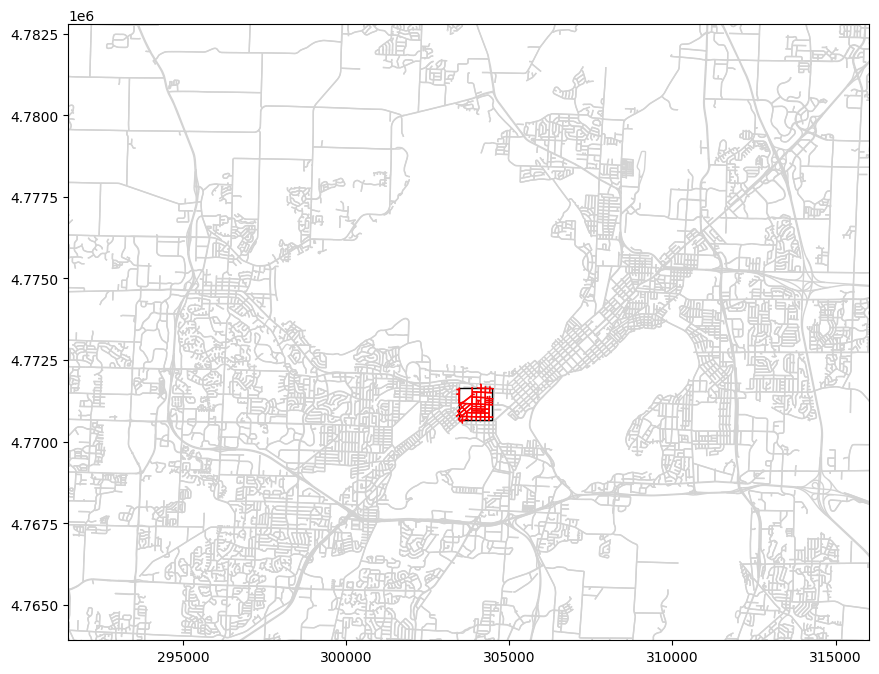

In [22]:
#visualizing the selected road with bounding
fig, ax = plt.subplots(figsize=(12,8))
data.plot(ax=ax,linewidth=1, edgecolor='lightgrey')
grid.boundary.plot(ax=ax,linewidth=1, edgecolor='black')
grid_road.plot(ax=ax,linewidth=1, edgecolor='red')

# Set the limits for x and y axes
ax.set_xlim([291479.066323136, 316040.8190105156])
ax.set_ylim([4763910.481721218, 4782787.64617454])

plt.show()

In [23]:
#selet some road with bounding box
width=1000
xmin,ymin,xmax,ymax=data.total_bounds
random_x = 308559.5
random_y = 4774148.5
square = Polygon([(random_x - width/2, random_y - width/2),
                  (random_x + width/2, random_y - width/2),
                  (random_x + width/2, random_y + width/2),
                  (random_x - width/2, random_y + width/2)])
grid = gpd.GeoDataFrame({'geometry': [square]}, crs=crs)

In [24]:
grid_road = gpd.sjoin( data,grid, how="inner", predicate="intersects")
hospital_nodes,time,time1 = [],[],[]
hospital_road = data[data['havehospital']==1]
for line in hospital_road.itertuples():
    first = (round(line.geometry.coords[0][0],4),round(line.geometry.coords[0][1],4))
    hospital_nodes.append(first)
for index,line in enumerate(grid_road.itertuples()):
    first = (round(line.geometry.coords[0][0],4),round(line.geometry.coords[0][1],4))
    last =  (round(line.geometry.coords[-1][0],4),round(line.geometry.coords[-1][1],4))
    for h in hospital_nodes:
        shortest_path_length0 = nx.shortest_path_length(G, source=first, target=h, weight='weight')
        shortest_path_length1 = nx.shortest_path_length(G, source=last, target=h, weight='weight')
        shortest_path_length3 = nx.shortest_path_length(G, source=first, target=h, weight='weight1')
        shortest_path_length4 = nx.shortest_path_length(G, source=last, target=h, weight='weight1')
        time.append(shortest_path_length0)
        time.append(shortest_path_length1)
        time1.append(shortest_path_length3)
        time1.append(shortest_path_length4)
    print('complete%s'%(index+1),'total%s'%len(grid_road))
print('the average time with flow reduction',sum(time)/len(time),'seconds')
print('the average time without flow reduction',sum(time1)/len(time1),'seconds')

complete1 total336
complete2 total336
complete3 total336
complete4 total336
complete5 total336
complete6 total336
complete7 total336
complete8 total336
complete9 total336
complete10 total336
complete11 total336
complete12 total336
complete13 total336
complete14 total336
complete15 total336
complete16 total336
complete17 total336
complete18 total336
complete19 total336
complete20 total336
complete21 total336
complete22 total336
complete23 total336
complete24 total336
complete25 total336
complete26 total336
complete27 total336
complete28 total336
complete29 total336
complete30 total336
complete31 total336
complete32 total336
complete33 total336
complete34 total336
complete35 total336
complete36 total336
complete37 total336
complete38 total336
complete39 total336
complete40 total336
complete41 total336
complete42 total336
complete43 total336
complete44 total336
complete45 total336
complete46 total336
complete47 total336
complete48 total336
complete49 total336
complete50 total336
complete5

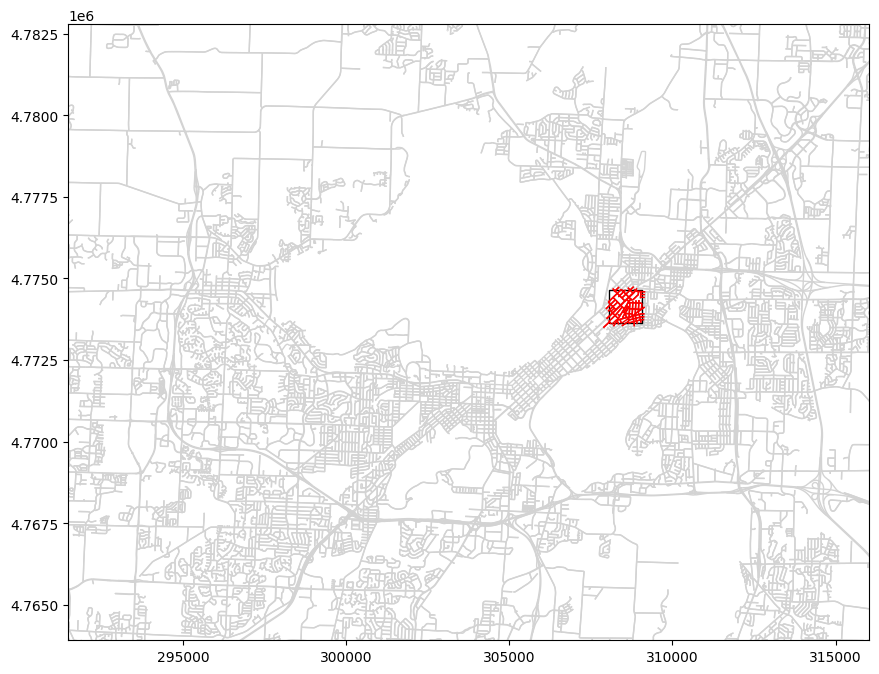

In [25]:
#visualizing the selected road with bounding
fig, ax = plt.subplots(figsize=(12,8))
data.plot(ax=ax,linewidth=1, edgecolor='lightgrey')
grid.boundary.plot(ax=ax,linewidth=1, edgecolor='black')
grid_road.plot(ax=ax,linewidth=1, edgecolor='red')

# Set the limits for x and y axes
ax.set_xlim([291479.066323136, 316040.8190105156])
ax.set_ylim([4763910.481721218, 4782787.64617454])

plt.show()

In [25]:
#selet some road with bounding box
width=1000
xmin,ymin,xmax,ymax=data.total_bounds
random_x = 305359.5
random_y = 4771748.5
square = Polygon([(random_x - width/2, random_y - width/2),
                  (random_x + width/2, random_y - width/2),
                  (random_x + width/2, random_y + width/2),
                  (random_x - width/2, random_y + width/2)])
grid = gpd.GeoDataFrame({'geometry': [square]}, crs=crs)

In [26]:
grid_road = gpd.sjoin( data,grid, how="inner", predicate="intersects")
hospital_nodes,time,time1 = [],[],[]
hospital_road = data[data['havehospital']==1]
for line in hospital_road.itertuples():
    first = (round(line.geometry.coords[0][0],4),round(line.geometry.coords[0][1],4))
    hospital_nodes.append(first)
for index,line in enumerate(grid_road.itertuples()):
    first = (round(line.geometry.coords[0][0],4),round(line.geometry.coords[0][1],4))
    last =  (round(line.geometry.coords[-1][0],4),round(line.geometry.coords[-1][1],4))
    for h in hospital_nodes:
        shortest_path_length0 = nx.shortest_path_length(G, source=first, target=h, weight='weight')
        shortest_path_length1 = nx.shortest_path_length(G, source=last, target=h, weight='weight')
        shortest_path_length3 = nx.shortest_path_length(G, source=first, target=h, weight='weight1')
        shortest_path_length4 = nx.shortest_path_length(G, source=last, target=h, weight='weight1')
        time.append(shortest_path_length0)
        time.append(shortest_path_length1)
        time1.append(shortest_path_length3)
        time1.append(shortest_path_length4)
    print('complete%s'%(index+1),'total%s'%len(grid_road))
print('the average time with flow reduction',sum(time)/len(time),'seconds')
print('the average time without flow reduction',sum(time1)/len(time1),'seconds')

complete1 total207
complete2 total207
complete3 total207
complete4 total207
complete5 total207
complete6 total207
complete7 total207
complete8 total207
complete9 total207
complete10 total207
complete11 total207
complete12 total207
complete13 total207
complete14 total207
complete15 total207
complete16 total207
complete17 total207
complete18 total207
complete19 total207
complete20 total207
complete21 total207
complete22 total207
complete23 total207
complete24 total207
complete25 total207
complete26 total207
complete27 total207
complete28 total207
complete29 total207
complete30 total207
complete31 total207
complete32 total207
complete33 total207
complete34 total207
complete35 total207
complete36 total207
complete37 total207
complete38 total207
complete39 total207
complete40 total207
complete41 total207
complete42 total207
complete43 total207
complete44 total207
complete45 total207
complete46 total207
complete47 total207
complete48 total207
complete49 total207
complete50 total207
complete5

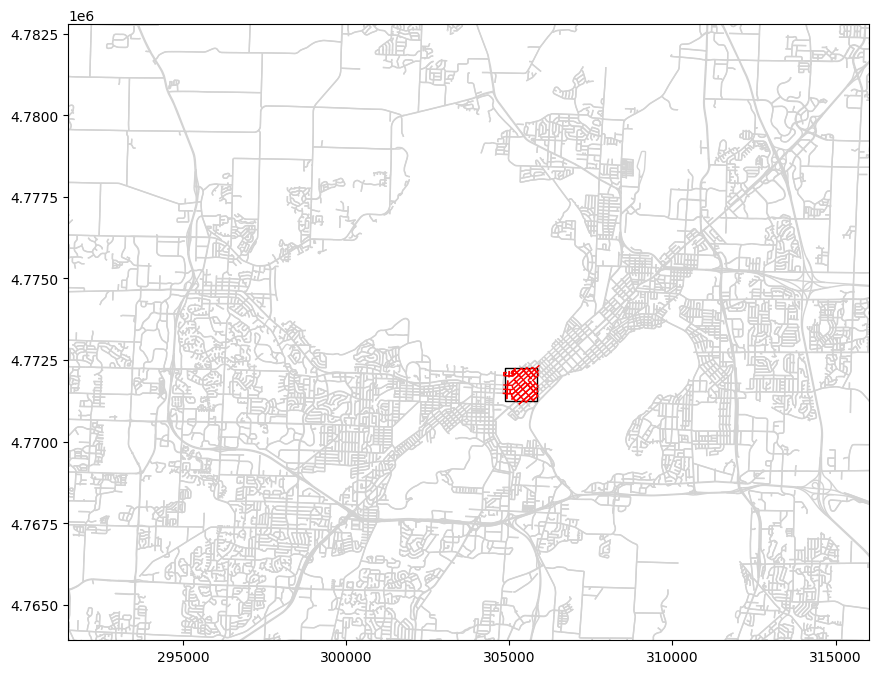

In [27]:
#visualizing the selected road with bounding
fig, ax = plt.subplots(figsize=(12,8))
data.plot(ax=ax,linewidth=1, edgecolor='lightgrey')
grid.boundary.plot(ax=ax,linewidth=1, edgecolor='black')
grid_road.plot(ax=ax,linewidth=1, edgecolor='red')

# Set the limits for x and y axes
ax.set_xlim([291479.066323136, 316040.8190105156])
ax.set_ylim([4763910.481721218, 4782787.64617454])

plt.show()